<span style="color:gray">
Copyright &copy; 2020-2021 by Fraunhofer-Gesellschaft. All rights reserved.<br>
Fraunhofer Institute for Integrated Circuits IIS, Division Engineering of Adaptive Systems EAS<br>
Zeunerstraße 38, 01069 Dresden, Germany
</span>

---

# Condition Monitoring of Drive Trains by Data Fusion of Acoustic Emission and Vibration Sensors

### Oliver Mey, André Schneider, Olaf Enge-Rosenblatt, Dirk Mayer, Christian Schmidt, Samuel Klein and Hans-Georg Herrmann

---

## Notebook *ClassifierTraining_03_VB_AE_FFT_CombinedDenseModel*

This notebook demonstrates the training of a classification model based on a combination of three neural networks. For the classification the Vibration signals as well as the Acoustic Emission signals are used.  

---

<span style="color:gray">
Version: 1.0.10 (June 15, 2021) <br>
Authors: André Schneider, Oliver Mey 
 </span>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import numpy as np
import pandas as pd
import urllib, json
import seaborn as sns
import colorcet as cc
import tensorflow as tf
import scipy as sc
import scipy.signal as scs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from glob import glob
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Softmax, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

sns.set(rc={'figure.figsize':(16, 4)})

In [2]:
project = 'SkaliSens_07'
experiment = 'ClassifierTraining_03'
approach = 'VB_AE_FFT_CombinedDenseModel'
revision = '$Id$'

## Configuration

The **path** must specify the directory into which the Fordatis data set was downloaded and unpacked.

This notebook demonstrates the classification based on a combination of the measured Acoustic Emission signals and the Vibration signals. 29 measurement series are available. 22 series (**masks=['1\*1', '3\*']**) are used for the training and test of the classification model. 7 series (**masks_evaluate=['1\*2']**) are used for the evaluation of the trained model.

The feature extraction is performed as follows: From the measurement series all time frames with a constant rotation speed of 600rpm and 1000rpm are selected (**speed=[600, 1000]**). For each frame the mean, the standard deviation, and certain ranges of the calculated FFT spectrums (Vibration: 10Hz...20kHz, Acoustic Emission: 512Hz...50kHz, **crop=[[10.0, 2000.0], [512.0, 50.0e3]]**) are used as feature vectors.

The combined classification model consists of three models: one model uses the extracted features based on the Acoustic Emission signals as input, one model uses the extracted features based on the Vibration signals as input. The third model combines the outputs of these two models.

At the end the combined model is evaluated and the confusion matrix representing the classification accuracy is plotted.

In [3]:
path = 'fordatis'
masks = ['1*1', '3*']
masks_evaluate = ['1*2']
speeds = [600, 1000]
labels = ['None', 'Inner', 'Outer', 'Balls']
categories = ['No defect', 'Inner ring defect', 'Outer ring defect', 'Rolling element defect']
sensors = ['vb', 'ae']
frame = 16
frequencies = [8192.0, 390625.0]
crop = [[10.0, 2000.0], [512.0, 50.0e3]]

In [4]:
f_vb = np.linspace(0.0, frequencies[0]/2,4097)
f_ae = np.linspace(0.0, frequencies[1]/2,4001)
i1 = np.argwhere(f_vb >= crop[0][0])[0][0]
i2 = np.argwhere(f_vb <= crop[0][1])[-1][0]
inputs_vb = i2 - i1
crop_vb = [slice(None, None),slice(i1, i2)]
i1 = np.argwhere(f_ae >= crop[1][0])[0][0]
i2 = np.argwhere(f_ae <= crop[1][1])[-1][0]
inputs_ae = i2 - i1
crop_ae = [slice(None, None),slice(i1, i2)]
t_vb = np.linspace(0, 1e9, 8192)
t_ae = np.linspace(0.0, 20.48e6, 8000)
crops = {'vb':crop_vb, 'ae':crop_ae}

## Function Definitions fo Feature Extraction

#### Utility Functions

In [5]:
def fir_(y, u, nb):
    N = y.size - nb -1
    phi = np.zeros(nb)
    PHI = np.zeros((N, nb))
    for i in range(N):
        phi[0:nb] = u[nb+i:i:-1]
        PHI[i, :] = phi
    W = np.dot(np.linalg.pinv(PHI.T @ PHI), PHI.T @ y[nb+1:])
    return W

def wiener_(df, f_remove, fps, duration, A=1, order=2):
    t = np.linspace(0,duration, int(fps*duration))
    X = df.values
    for fc in f_remove:
        for i in range(X.shape[0]):
            u = A * np.sin(2 * np.pi * fc * t / duration)
            W = fir_(X[i,:], u, order)
            ym = np.zeros(order)
            yout  = np.zeros_like(X[i,:])
            for k, _ in enumerate(u):
                yout[k] = np.dot(W, ym)
                ym = np.hstack((np.array(u[k]), ym[0:-1]))
            X[i,:]=X[i,:] - yout
    df_out = df.copy()
    df_out.iloc[:,:] = X
    return df_out

#### Functions for Feature Extraction Pipeline

Based on the following functions a *Feature Extraction Pipeline* can be created. Each function takes a list of measurements for each sensor (*X*) and a set of parameters (*P*). The input data can be transformed. The result (with same structure as the input) is then returned (*X*).

The function **synchronize()** synchronizes the measurements of all sensors based on the time axis with a 1s resolution. The function **select()** selects one frame per second (e.g. **frame=12**). Since for the Acoustic Emissions signals around 20 frames per second are measured, all remaining frames are discarded. The function **crop()** cuts off the lower and upper parts of the FFT spectrums as configured above (see **crop=[]**). The function **fft()** calcuated the FFT spectrum for each frame. The functions **kurtsis()** and **skewness()** calculate statistical values per frame. The functions **bessel()** and **wiener()** implement the corresponding signal filter functions. Finally, the function **mean_std_fft_crop()** contains a combination of several feature extraction steps within a single function. 

In [6]:
def synchronize(X, P=None):
    X[1] = X[1][X[1].index.floor('s').isin(X[0].index.floor('s'))]
    X[0] = X[0][X[0].index.floor('s').isin(X[1].index.floor('s'))]
    return X

def select(X, P=None):
    p = P[0]
    x = X[1].groupby(X[1].index.floor('s')).nth([0, p['frame']])
    X[1] = x.groupby(x.index.floor('s')).last()
    return X

def shrink(X, P=None):
    I = range(len(P))
    t_ranges = [[get_time_range(p['t_ranges'], speed=speed) for speed in p['speeds']] for p in P]
    X = [pd.concat([x[x.index.to_series().between(t[0], t[1])] for t in t_ranges[i]]) for x,i in zip(X,I)]
    return X

def crop(X, P=None):
    crops = [(p['rows'], p['columns']) for p in P]
    X = [x.iloc[crop] for x,crop in zip(X,crops)]
    return X

def fft(X, P=None):
    X = [pd.DataFrame(np.abs(np.fft.rfft(x))) for x in X]
    for x in X: x[0]=0
    return X

def kurtosis(X, P=None):
    X = [pd.DataFrame(sc.stats.kurtosis(x)) for x in X]
    return X

def skewness(X, P=None):
    X = [pd.DataFrame(sc.stats.skew(x)) for x in X]
    return X

def bessel(X, P=None):
    b, a = scs.bessel(N=4, Wn=5, btype='highpass', analog=False, norm='phase', fs=frequencies[0])
    x = X[0].copy()
    x = scs.filtfilt(b,a,x.values.flatten()).reshape(-1, int(frequencies[0]))
    X[0] = pd.DataFrame(x)
    return X

def wiener(X, P=None):
    x = X[0].copy()
    f_remove = [50, 100, 200, 300, 400, 500]
    duration = 1.0
    X[0] = wiener_(x, f_remove, frequencies[0], duration)
    return X

def mean_std_fft_crop(X, P=None):
    mean = [x.mean(axis=1) for x in X]
    std = [x.std(axis=1) for x in X]
    X = [pd.DataFrame(np.abs(np.fft.rfft(x))) for x in X]
    for x in X: x[0]=0
    crops = [(p['rows'], p['columns']) for p in P]
    X = [x.iloc[crop] for x,crop in zip(X,crops)]
    for i in range(len(X)):
        X[i]['mean'] = mean[i].values
        X[i]['std'] = std[i].values
    return X

## Function Definitions for Data Preparation and Model Training

In [7]:
def setup(path, masks):
    files = [sorted(glob(path + '/data/' + mask)) for mask in masks]
    files = list(chain(*files))
    measurements = [os.path.basename(str(file)) for file in files]
    descriptors = [pd.read_json(path + '/measurements/' + measurement + '.json') 
                   for measurement in measurements]
    usecases = [labels.index(descriptor.loc['usecasegroup', 'measurement']) 
                for descriptor in descriptors]
    return measurements, usecases

def load_time_ranges(path, measurements, speeds):
    w = [load_samples(path, measurement, sensor='w') for measurement in measurements]
    for wi in w: wi.columns = ['w']
    t_ranges = [[wi[wi['w'] == speed].index.to_numpy() for speed in speeds] for wi in w]
    return t_ranges

def get_time_range(t, speed=600):
    return t[speeds.index(speed)][0], t[speeds.index(speed)][1]

def load_samples(path, measurement, sensor):
    samples = pd.read_csv(path + '/data/' + measurement + '/' + sensor + '.csv', 
                   parse_dates=[0], index_col=0, sep=' ', header=None)
    samples.index = samples.index.values.astype('datetime64[us]')
    return samples

def extract_features(X, F, P, U):
    for f in F: X = [f(x,p) for x,p in zip(X,P)]
    X = [x[0].join(x[1], lsuffix='vb', rsuffix='ae') for x in X]
    N = [x.shape[0] for x in X]
    X = pd.concat(X).to_numpy()
    X = X.reshape(X.shape[0], X.shape[1])
    y = [pd.DataFrame(np.ones(N[i])*U[i], dtype=np.int8) for i in range(len(U))]
    y = pd.concat(y).to_numpy()
    y = y.reshape(-1)
    w = [len(y[y==usecase]) for usecase in np.unique(U)]
    w = dict(enumerate(w))
    return X,y,w

def create_model(X, w):
    n_layers_ae = 3
    n_layers_vb = 2
    n_inputs_ae = inputs_ae + 2
    n_inputs_vb = inputs_vb + 2

    X_in_ae = Input(shape=(n_inputs_ae,), name="ae_input")
    x = X_in_ae
    for j in range(n_layers_ae):
        x = Dense(units = 1024, activation="linear", name='ae_dense_'+str(j))(x)
        x = LeakyReLU(alpha=0.05, name='ae_relu_'+str(j))(x)
        x = Dropout(rate=0.1, name='ae_dropout_'+str(j))(x) 
    X_out_ae_pre = Dense(units = 4, activation = 'linear', name="ae_output_before_activation")(x)
    X_out_ae = Softmax(name="ae_output")(X_out_ae_pre)   
    model_ae = Model(X_in_ae, X_out_ae)

    X_in_vb = Input(shape=(n_inputs_vb,), name="vb_input")
    x = X_in_vb
    for j in range(n_layers_vb):
        x = Dense(units = 1024, activation="linear", name='vb_dense_'+str(j))(x)
        x = LeakyReLU(alpha=0.05, name='vb_relu_'+str(j))(x)
        x = Dropout(rate=0.2, name='vb_dropout_'+str(j))(x)
    X_out_vb_pre = Dense(units = 4, activation = 'linear', name="vb_output_before_activation")(x)
    X_out_vb = Softmax(name="vb_output")(X_out_vb_pre)    
    model_vb = Model(X_in_vb, X_out_vb)

    combined = concatenate([model_ae.layers[-4].output, model_vb.layers[-4].output])
    x = Dense(units = 128, activation="linear", name='dense_0')(combined)
    x = LeakyReLU(alpha=0.05, name='relu_0')(x)
    x = Dense(units = 128, activation="linear", name='dense_1')(x)
    x = LeakyReLU(alpha=0.05, name='relu_1')(x)
    X_out = Dense(units = 4, activation = 'softmax', name="combined_output")(x)

    model = Model(inputs=[model_ae.input, model_vb.input], 
                      outputs=[X_out_ae, X_out_vb, X_out])

    model_ae.compile(optimizer = Adam(lr=0.0005), loss = 'categorical_crossentropy', 
                     metrics = ['accuracy'])
    model_vb.compile(optimizer = Adam(lr=0.0005), loss = 'categorical_crossentropy', 
                      metrics = ['accuracy'])
    model.compile(optimizer = Adam(lr=0.0005), loss = 'categorical_crossentropy', 
                      metrics = ['accuracy'])
    model.summary()
    return model_vb, model_ae, model

def train_model(X, y, w, model_vb, model_ae, model):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(y.reshape(-1, 1))
    y = encoder.transform(y.reshape(-1, 1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train_vb = X_train[:,:inputs_vb+2]
    X_test_vb = X_test[:,:inputs_vb+2]
    X_train_ae = X_train[:,-(inputs_ae+2):]
    X_test_ae = X_test[:,-(inputs_ae+2):]
    scaler_vb = RobustScaler(quantile_range=(5,95)).fit(X_train_vb)
    X_train_vb = scaler_vb.transform(X_train_vb)
    X_test_vb = scaler_vb.transform(X_test_vb)
    scaler_ae = RobustScaler(quantile_range=(5,95)).fit(X_train_ae)
    X_train_ae = scaler_ae.transform(X_train_ae)
    X_test_ae = scaler_ae.transform(X_test_ae)
    
    checkpoint = ModelCheckpoint('./model_vb_03.h5', monitor='val_accuracy', verbose=1,
                                 save_best_only=True, mode='max')
    model_vb.fit(X_train_vb, y_train, epochs = 100, batch_size = 128, 
                 validation_data=(X_test_vb, y_test), class_weight=w, callbacks=[checkpoint])
    
    checkpoint = ModelCheckpoint('./model_ae_03.h5', monitor='val_accuracy', verbose=1,
                                 save_best_only=True, mode='max')
    model_ae.fit(X_train_ae, y_train, epochs = 50, batch_size = 128, 
                 validation_data=(X_test_ae, y_test), class_weight=w, callbacks=[checkpoint])
    
    model_ae.trainable = False
    model_vb.trainable = False
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train_vb = X_train[:,:inputs_vb+2]
    X_test_vb = X_test[:,:inputs_vb+2]
    X_train_ae = X_train[:,-(inputs_ae+2):]
    X_test_ae = X_test[:,-(inputs_ae+2):]
    scaler_vb = RobustScaler(quantile_range=(5,95)).fit(X_train_vb)
    X_train_vb = scaler_vb.transform(X_train_vb)
    X_test_vb = scaler_vb.transform(X_test_vb)
    scaler_ae = RobustScaler(quantile_range=(5,95)).fit(X_train_ae)
    X_train_ae = scaler_ae.transform(X_train_ae)
    X_test_ae = scaler_ae.transform(X_test_ae)
    
    checkpoint = ModelCheckpoint('./model_03.h5', monitor='val_combined_output_accuracy', verbose=1,
                                 save_best_only=True, mode='max')
    model.fit([X_train_ae, X_train_vb], y_train, epochs = 100, batch_size = 128,
                  validation_data=([X_test_ae, X_test_vb], y_test), callbacks=[checkpoint])
    return model, encoder, scaler_vb, scaler_ae

def evaluate_model(X, y, model, encoder, scaler_vb, scaler_ae):
    encoder.fit(y.reshape(-1, 1))
    y = encoder.transform(y.reshape(-1, 1))
    X_vb = X[:,:(inputs_vb+2)]
    X_ae = X[:,-(inputs_ae+2):]
    X_vb = scaler_vb.transform(X_vb)
    X_ae = scaler_ae.transform(X_ae)
    y_predict = model.predict([X_ae, X_vb])
    return y, y_predict

def plot_results(y, y_predict):
    confusion = tf.math.confusion_matrix(labels=tf.argmax(y,1),
                                         predictions=tf.argmax(y_predict,1))
    confusion = tf.make_ndarray(tf.make_tensor_proto(confusion))
    cm = pd.DataFrame(confusion, index = ["None", "Inner", "Outer", "Ball"],
                      columns = ["None", "Inner", "Outer", "Ball"])
    fig=plt.figure(figsize = (10,8))
    sns.heatmap(cm/np.sum(cm, axis=1).values.reshape(-1,1), annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("Actual Labels")
    plt.xlabel("Predicted Labels")
    plt.show()
    fig=plt.figure(figsize = (10,8))
    ax1=plt.subplot(111)
    c = ax1.pcolor(y_predict, cmap=plt.get_cmap('Blues'))
    fig.colorbar(c, ax=ax1)
    ax1.set_xticks([0.5, 1.5, 2.5, 3.5])
    ax1.set_xticklabels(["None", "Inner", "Outer", "Ball"])
    plt.show()
    return

## Setup of Feature Extraction Pipeline

In [8]:
functions = [shrink, bessel, wiener, mean_std_fft_crop]

## Loading and Preprocessing of Data

In [9]:
measurements, usecases = setup(path, masks)
t_ranges = load_time_ranges(path, measurements, speeds)
parameters = [[dict([('t_ranges', t), ('rows', crops[sensor][0]), ('columns', crops[sensor][1]),
           ('frame', frame), ('speeds', speeds)]) for sensor in sensors] for t in t_ranges]

In [10]:
samples = [[load_samples(path, measurement, sensor) for sensor in sensors] for measurement in measurements]

## Feature Extraction

In [11]:
X, y, w = extract_features(samples, functions, parameters, usecases)

## Creating and Compiling the Model Structure

In [12]:
model_vb, model_ae, model = create_model(X, w)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ae_input (InputLayer)           [(None, 1015)]       0                                            
__________________________________________________________________________________________________
ae_dense_0 (Dense)              (None, 1024)         1040384     ae_input[0][0]                   
__________________________________________________________________________________________________
ae_relu_0 (LeakyReLU)           (None, 1024)         0           ae_dense_0[0][0]                 
__________________________________________________________________________________________________
ae_dropout_0 (Dropout)          (None, 1024)         0           ae_relu_0[0][0]                  
____________________________________________________________________________________________

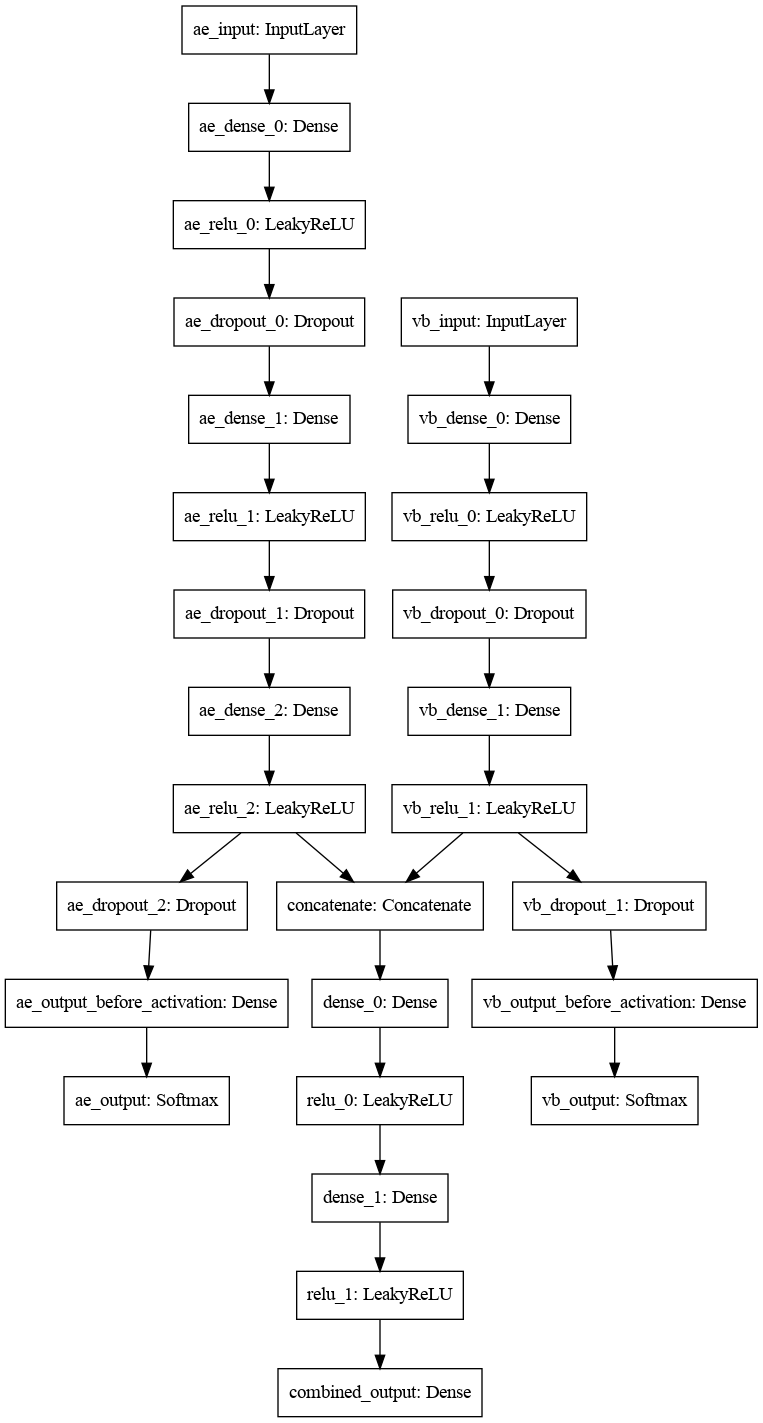

In [13]:
plot_model(model)

## Training of the Model

In [ ]:
model, encoder, scaler_vb, scaler_ae = train_model(X, y, w, model_vb, model_ae, model)

## Evaluation of the Trained Model Using a Different Dataset

In [15]:
measurements, usecases = setup(path, masks_evaluate)
t_ranges = load_time_ranges(path, measurements, speeds)
parameters = [[dict([('t_ranges', t), ('rows', crops[sensor][0]), ('columns', crops[sensor][1]),
           ('frame', frame), ('speeds', speeds)]) for sensor in sensors] for t in t_ranges]

In [16]:
samples = [[load_samples(path, measurement, sensor) for sensor in sensors] for measurement in measurements]
X_evaluate, y_evaluate, _ = extract_features(samples, functions, parameters, usecases)

In [17]:
y_evaluate, y_predict = evaluate_model(X_evaluate, y_evaluate, model, encoder, scaler_vb, scaler_ae)

## Classification for Acoustic Emissions

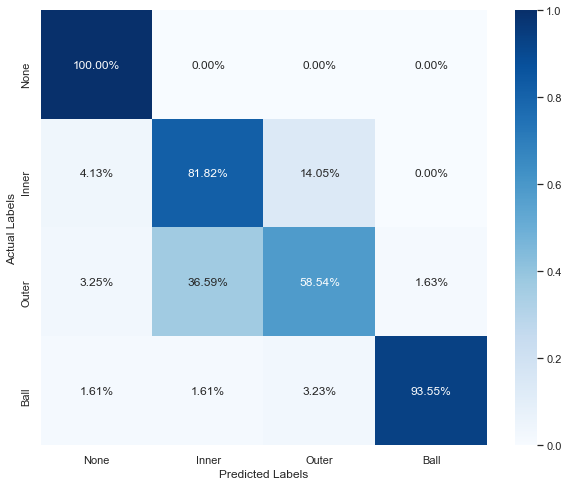

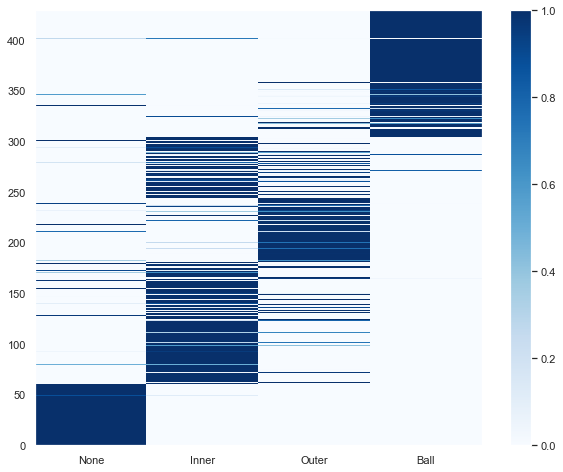

In [18]:
plot_results(y_evaluate, y_predict[0])

## Classification for Vibrations

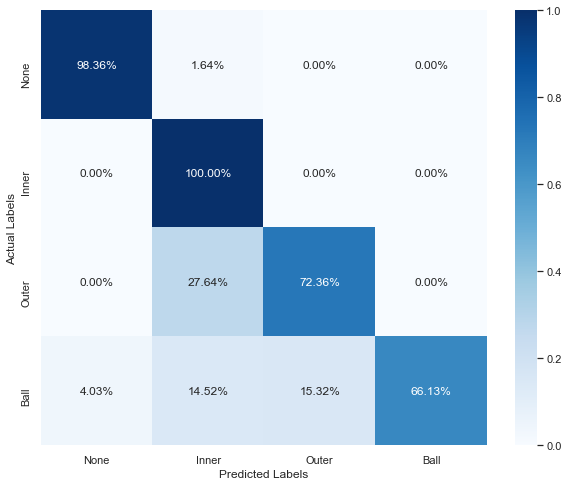

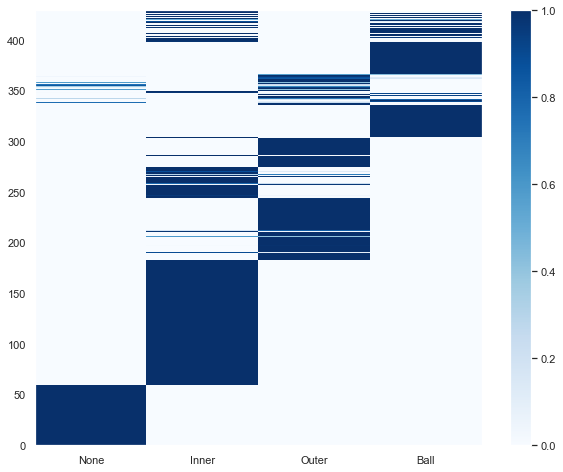

In [19]:
plot_results(y_evaluate, y_predict[1])

## Combined Classification

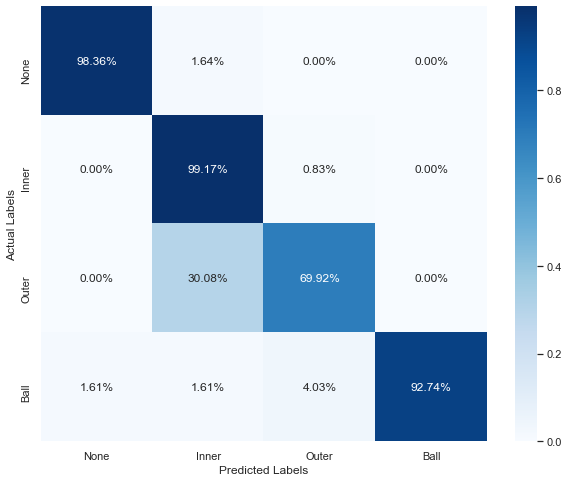

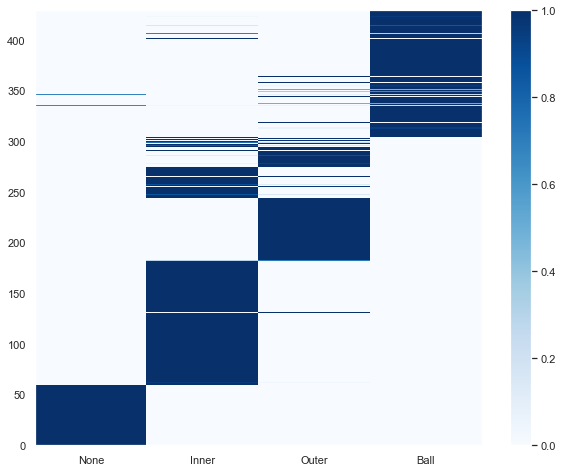

In [20]:
plot_results(y_evaluate, y_predict[2])